In [2]:
# Full evaluation & interpretability script
# Run in a Jupyter cell. Adjust paths if needed.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    balanced_accuracy_score,
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import cv2
import json

# -------------------------
# CONFIG
# -------------------------
MODEL_PATH = "models/model5.keras"      # path to saved model
TEST_DIR = "dataset/test"               # test directory root
IMG_SIZE = (128, 128)                   # must match model's expected input
BATCH_SIZE = 64
OUTPUT_DIR = "evaluation_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# 1) Load test dataset (recreate to be safe)
# -------------------------
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
)

class_names = test_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)



Found 1062 files belonging to 10 classes.
Classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


In [3]:
# -------------------------
# 2) Load model (safe load)
# -------------------------
assert os.path.exists(MODEL_PATH), f"Model not found: {MODEL_PATH}"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)  # load without custom-loss compiling
# Recompile with an evaluation-safe loss/metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # optimizer won't be used for evaluation beyond metrics
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Model summary (also save)
model.summary()
with open(os.path.join(OUTPUT_DIR, "model_summary.txt"), "w") as f:
    model.summary(print_fn=lambda s: f.write(s + "\n"))

# -------------------------
# 3) Evaluate on test set
# -------------------------
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss:.4f}   Test accuracy: {test_acc:.4f}")



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │        896 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ activation_22[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 16, 16,    │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    131,328 │ max_pooling2d_20… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 3,988,266 (15.21 MB)

 Trainable params: 3,984,746 (15.20 MB)

 Non-trainable params: 3,520 (13.75 KB)

2025-11-09 10:10:43.841675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8296 - loss: 0.5548
Test loss: 0.5548   Test accuracy: 0.8296


In [4]:
# -------------------------
# 4) Predict on test set (probabilities) and gather true labels
# -------------------------
# Pred probs (shape: [N_samples, num_classes])
probs = model.predict(test_ds, verbose=1)
y_pred = np.argmax(probs, axis=1)

# True labels: concatenate batches
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
# If labels are one-hot (unlikely), convert to ints
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

assert y_true.shape[0] == probs.shape[0], "Mismatch between preds and ground truth length"

# Save predictions CSV (file path, true, pred, prob_vector)
# To map filenames to predictions we need the dataset file order - recreate listing
file_paths = []
for batch in test_ds.unbatch().map(lambda x, y: x):
    # cannot get filename from tensor dataset directly; instead build list from disk
    break

# Build file list based on directory order (image_dataset_from_directory uses alphanumeric order within classes)
paths = []
for cls in class_names:
    cls_folder = os.path.join(TEST_DIR, cls)
    imgs = sorted(os.listdir(cls_folder))
    for im in imgs:
        paths.append(os.path.join(cls_folder, im))
# The order above will match image_dataset_from_directory if no extra shuffling and default settings
paths = paths[: len(y_true)]  # safety trim

df_preds = pd.DataFrame({
    "filepath": paths,
    "true_idx": y_true,
    "true_label": [class_names[i] for i in y_true],
    "pred_idx": y_pred,
    "pred_label": [class_names[i] for i in y_pred],
    "pred_conf": probs.max(axis=1)
})
# add probabilities columns
for i, cname in enumerate(class_names):
    df_preds[f"prob_{cname}"] = probs[:, i]

pred_csv = os.path.join(OUTPUT_DIR, "test_predictions.csv")
df_preds.to_csv(pred_csv, index=False)
print("Saved predictions to:", pred_csv)



17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
Saved predictions to: evaluation_outputs/test_predictions.csv


2025-11-09 10:10:56.360452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# -------------------------
# 5) Classification report & per-class metrics
# -------------------------
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
report_txt = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report_txt)
with open(os.path.join(OUTPUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report_txt)

# Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced accuracy: {bal_acc:.4f}")

# Save report json
with open(os.path.join(OUTPUT_DIR, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=2)



                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]     0.6897    1.0000    0.8163        20
                           Diabetic Retinopathy     0.9819    0.9003    0.9393       301
                                     Disc Edema     0.8333    1.0000    0.9091        25
                                       Glaucoma     0.8927    0.5874    0.7085       269
                                        Healthy     0.8027    0.8775    0.8384       204
                                   Macular Scar     0.7196    0.8750    0.7897        88
                                         Myopia     0.6234    0.9600    0.7559       100
                                      Pterygium     1.0000    1.0000    1.0000         3
                             Retinal Detachment     0.7812    1.0000    0.8772        25
                           Retinitis Pigmentosa     0.8710    1.0000    0.9310        27

                   

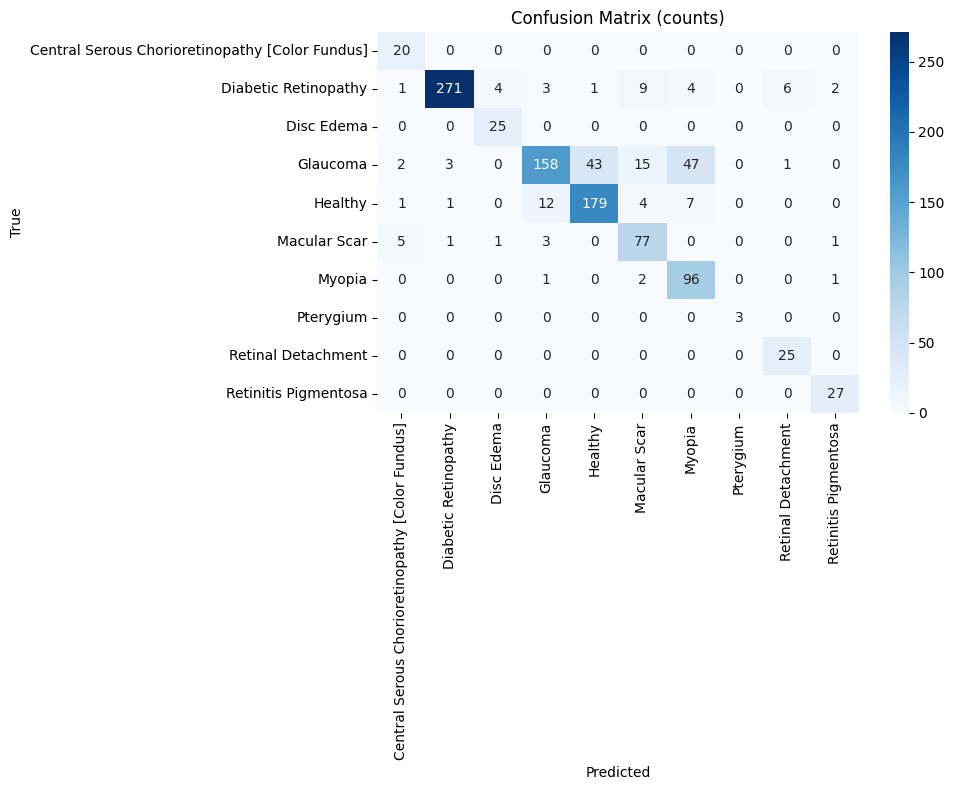

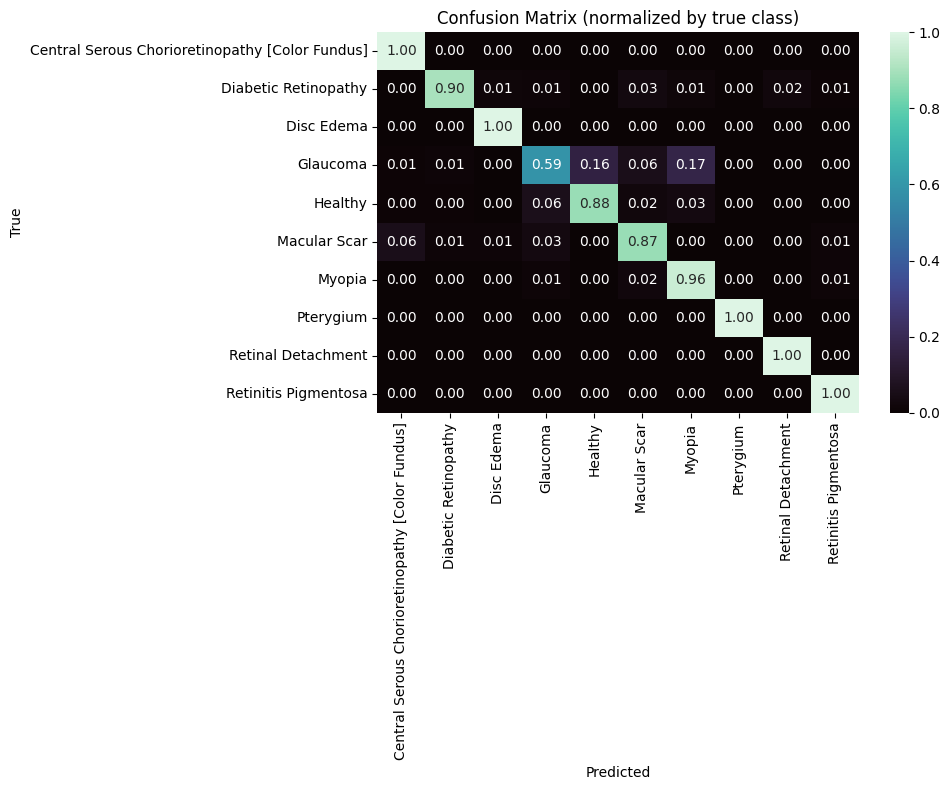

In [6]:
# -------------------------
# 6) Confusion matrix (counts + normalized) & plot
# -------------------------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_counts.png"), dpi=200)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="mako", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized by true class)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_normalized.png"), dpi=200)
plt.show()



Top-2 accuracy: 0.9746
Top-3 accuracy: 0.9906


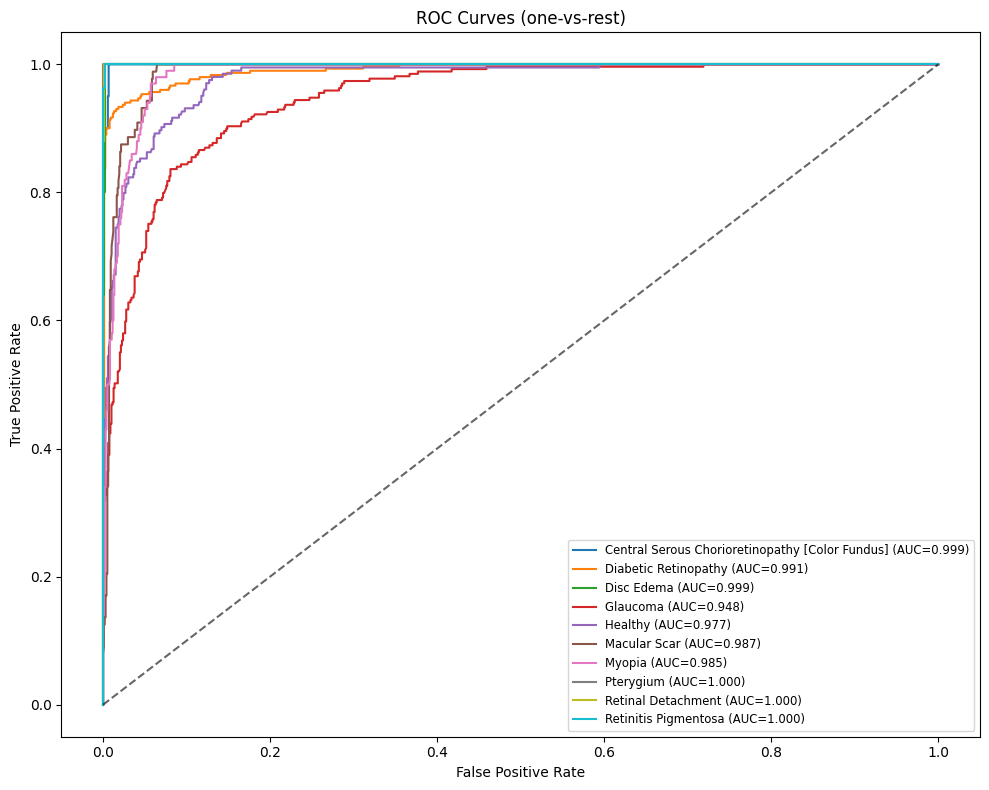

In [7]:
# -------------------------
# 7) Top-K accuracy (top-2, top-3)
# -------------------------
def top_k_accuracy(probs, y_true, k=2):
    topk = np.argsort(probs, axis=1)[:, -k:]
    return np.mean([y_true[i] in topk[i] for i in range(len(y_true))])

top2 = top_k_accuracy(probs, y_true, k=2)
top3 = top_k_accuracy(probs, y_true, k=3)
print(f"Top-2 accuracy: {top2:.4f}")
print(f"Top-3 accuracy: {top3:.4f}")

# -------------------------
# 8) ROC AUC (One-vs-Rest) & ROC curves per class
# -------------------------
# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(num_classes)))
# If single-class or binary, label_binarize handles it
if y_true_binarized.shape[1] != num_classes:
    # handle edge-case with single class present
    y_true_binarized = np.eye(num_classes)[y_true]

# Compute AUC per class (requires at least one positive sample per class)
roc_info = {}
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    try:
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        roc_info[class_names[i]] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "auc": float(roc_auc)}
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.3f})")
    except ValueError:
        # not enough classes to compute ROC for this class
        roc_info[class_names[i]] = {"fpr": [], "tpr": [], "auc": None}

plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (one-vs-rest)")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "roc_curves.png"), dpi=200)
plt.show()

with open(os.path.join(OUTPUT_DIR, "roc_info.json"), "w") as f:
    json.dump(roc_info, f, indent=2)



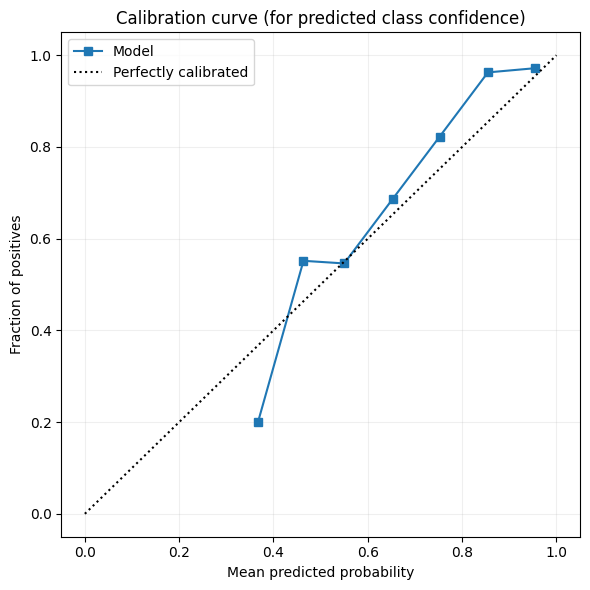

ECE (predicted-class confidences): 0.0457


In [8]:
# -------------------------
# 9) Calibration plot & ECE
# -------------------------
# We'll compute calibration for predicted class confidence (max prob)
probs_max = probs.max(axis=1)
fraction_of_positives, mean_predicted_value = calibration_curve((y_pred == y_true).astype(int), probs_max, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (for predicted class confidence)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "calibration_curve.png"), dpi=200)
plt.show()

# ECE (expected calibration error) implementation
def expected_calibration_error(y_true_bool, prob_pred, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        mask = (prob_pred >= bins[i]) & (prob_pred < bins[i + 1])
        if mask.sum() > 0:
            acc = y_true_bool[mask].mean()
            conf = prob_pred[mask].mean()
            ece += (mask.sum() / len(prob_pred)) * abs(acc - conf)
    return ece

ece_val = expected_calibration_error((y_pred == y_true).astype(int), probs_max, n_bins=10)
print(f"ECE (predicted-class confidences): {ece_val:.4f}")



In [9]:
# -------------------------
# 10) Save summary metrics to JSON
# -------------------------
summary = {
    "test_loss": float(test_loss),
    "test_accuracy": float(test_acc),
    "balanced_accuracy": float(bal_acc),
    "top2_accuracy": float(top2),
    "top3_accuracy": float(top3),
    "ece": float(ece_val),
}
with open(os.path.join(OUTPUT_DIR, "evaluation_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)



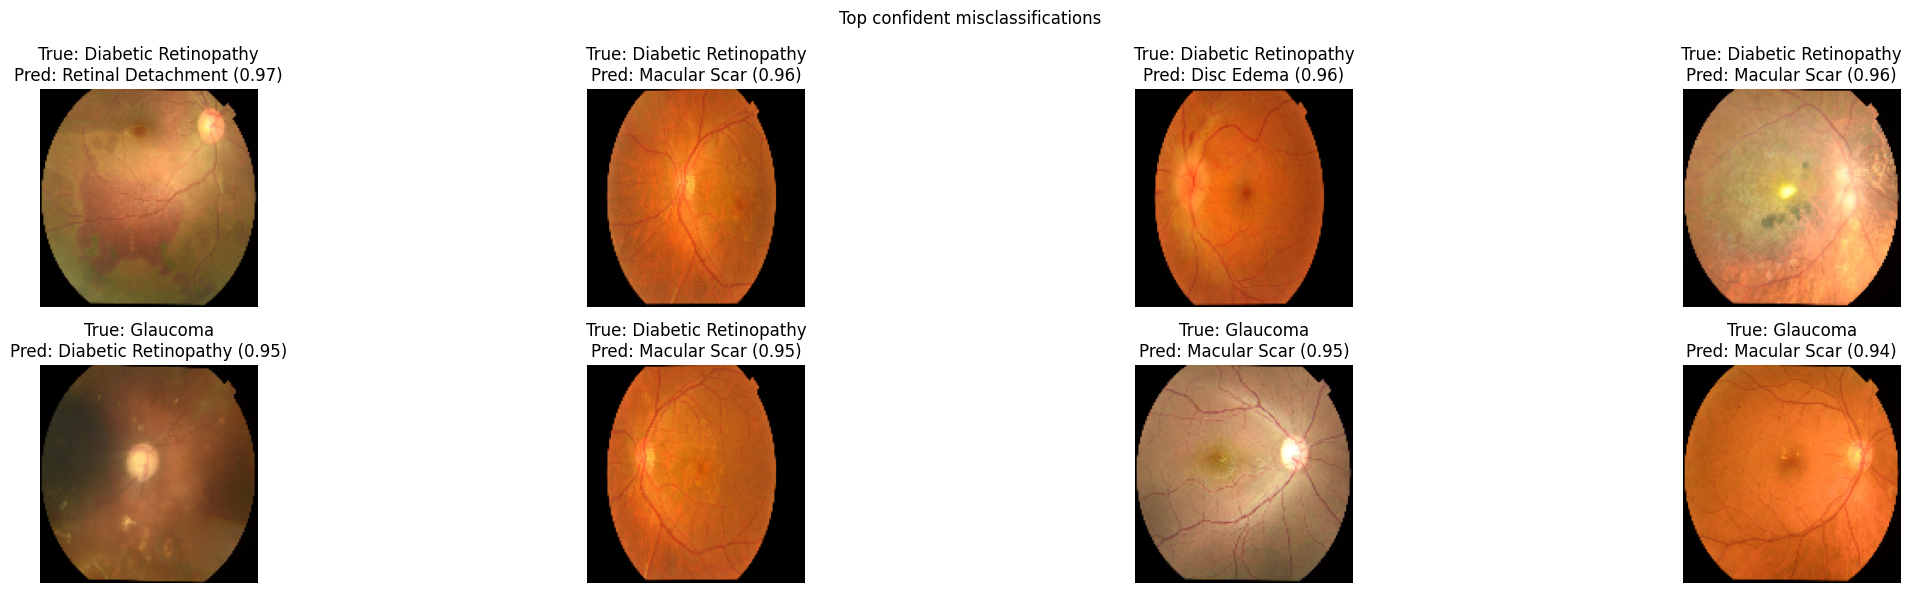

In [10]:
# -------------------------
# 11) Confident failure analysis: show some false positives / false negatives
# -------------------------
false_idx = np.where((y_pred != y_true))[0]
# sort failures by model confidence (descending) so we see confident mistakes
if len(false_idx) > 0:
    conf_of_false = probs_max[false_idx]
    sorted_fail_idx = false_idx[np.argsort(-conf_of_false)]
    n_show = min(8, len(sorted_fail_idx))
    fig, axes = plt.subplots(2, n_show//2 if n_show>=2 else 1, figsize=(3*n_show, 6))
    axes = np.array(axes).reshape(-1)
    for idx_plot, idx in enumerate(sorted_fail_idx[:n_show]):
        img_path = paths[idx]
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        arr = tf.keras.utils.img_to_array(img) / 255.0
        axes[idx_plot].imshow(arr)
        axes[idx_plot].axis('off')
        axes[idx_plot].set_title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]} ({probs_max[idx]:.2f})")
    plt.suptitle("Top confident misclassifications")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "confident_misclassifications.png"), dpi=200)
    plt.show()
else:
    print("No misclassifications found on test set.")



In [12]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import widgets, VBox, HBox, Button, Output, FloatSlider, Dropdown

# ----------------------------
# CONFIG
# ----------------------------
MODEL_PATH = "models/model5.keras"
TEST_DIR = "dataset/test"
IMG_SIZE = (128, 128)

# ----------------------------
# LOAD MODEL
# ----------------------------
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
class_names = sorted([d for d in os.listdir(TEST_DIR) 
                      if not d.startswith('.') and os.path.isdir(os.path.join(TEST_DIR, d))])
print("Classes:", class_names)


def list_images_safe(dir_path):
    """Return only image files, skip hidden/system files."""
    valid_files = [f for f in os.listdir(dir_path) 
                   if not f.startswith('.') and os.path.isfile(os.path.join(dir_path, f))]
    if not valid_files:
        raise ValueError(f"No valid image files found in {dir_path}")
    return valid_files


# ----------------------------
# GRAD-CAM / BBOX
# ----------------------------
def get_gradcam_box(model, img_array, last_conv_layer_name=None, threshold=0.6):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break
        if last_conv_layer_name is None:
            raise ValueError("No Conv2D layer found in model.")

    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    img_tensor = tf.expand_dims(img_array, 0)
    # Wrap in list if model expects list input
    if isinstance(model.inputs, list):
        img_tensor = [img_tensor]

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

    # ReLU & safe normalization
    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap)
    heatmap = heatmap / max_val if max_val > 0 else np.zeros_like(heatmap)

    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], IMG_SIZE).numpy().squeeze()

    # Threshold for bbox
    mask = heatmap_resized > threshold
    coords = np.argwhere(mask)
    if coords.size == 0:
        return heatmap_resized, preds[0].numpy(), None
    (y1,x1), (y2,x2) = coords.min(0), coords.max(0)
    box = (x1, y1, x2-x1, y2-y1)
    return heatmap_resized, preds[0].numpy(), box


# ----------------------------
# DISPLAY FUNCTION
# ----------------------------
def show_prediction(image_path, threshold=0.6):
    img = keras_image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras_image.img_to_array(img)  # let model handle rescaling

    # MC-Dropout optional (True/False)
    heatmap, probs, box = get_gradcam_box(model, img_array, threshold=threshold)

    pred_idx = np.argmax(probs)
    pred_class = class_names[pred_idx]
    true_class = os.path.basename(os.path.dirname(image_path))

    # Plot original and predicted with box
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_array/255.0)
    axs[0].set_title(f"True: {true_class}")
    axs[0].axis("off")

    axs[1].imshow(img_array/255.0)
    axs[1].set_title(f"Predicted: {pred_class}")
    axs[1].axis("off")

    if box is not None:
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3],
                                 linewidth=2, edgecolor='lime', facecolor='none')
        axs[1].add_patch(rect)

    plt.tight_layout()
    plt.show()

    # Softmax probabilities
    df = {cls: float(p) for cls, p in zip(class_names, probs)}
    sorted_df = dict(sorted(df.items(), key=lambda x: x[1], reverse=True))
    print("\nSoftmax probabilities:")
    for cls, p in sorted_df.items():
        print(f"{cls:25s}: {p:.4f}")

# ----------------------------
# INTERACTIVE UI
# ----------------------------
class_options = ["All classes"] + class_names
class_selector = Dropdown(options=class_options, description='Class:', layout={'width':'200px'})

threshold_slider = FloatSlider(value=0.6, min=0.1, max=0.9, step=0.05,
                               description='Threshold:', continuous_update=False,
                               layout={'width':'350px'})

predict_button = Button(description="Generate Random Sample",
                        button_style="success", layout={'width':'250px'})

out = Output()

def on_predict_click(b):
    with out:
        out.clear_output()
        # Pick class
        selected_class = class_selector.value
        if selected_class=="All classes":
            selected_class = random.choice(class_names)
        class_dir = os.path.join(TEST_DIR, selected_class)
        sample_file = random.choice(list_images_safe(class_dir))
        img_path = os.path.join(class_dir, sample_file)
        show_prediction(img_path, threshold_slider.value)

predict_button.on_click(on_predict_click)

ui = VBox([HBox([class_selector, threshold_slider, predict_button]), out])
display(ui)


Classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']
